# Imports

In [40]:
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import label_binarize
from keras.models import load_model
import random

# Constants

In [41]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
NUM_CLASSES = 10

# Directories (replace these paths with your dataset locations)
train_dir = './dataset/train'
val_dir = './dataset/val'
test_dir = './dataset/test'

# Function to create data generators

In [42]:
def create_data_generators(phase):
    if phase == 3:  # Data augmentation for Phase 3
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
    else:  # Only scaling for Phase 1 and Phase 2
        train_datagen = ImageDataGenerator(rescale=1./255)

    val_test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )
    val_generator = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )
    test_generator = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    return train_generator, val_generator, test_generator

# Function to train a model

In [43]:
def train_model(model, train_gen, val_gen, epochs=20, phase=1):
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=[early_stopping, reduce_lr]
    )
    # Save the model after training
    model.save(f'model_phase_{phase}.keras')
    print(f"Model for Phase {phase} saved as 'model_phase_{phase}.keras'")
    return history

# Function to plot learning curves

In [44]:
def plot_learning_curves(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

# Function to evaluate the model

In [45]:
def evaluate_model(model, test_gen):
    test_loss, test_accuracy = model.evaluate(test_gen)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")

    y_true = test_gen.classes
    y_pred_prob = model.predict(test_gen)
    y_pred = np.argmax(y_pred_prob, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))

    y_true_binary = label_binarize(y_true, classes=list(range(NUM_CLASSES)))
    plt.figure(figsize=(12, 8))
    for i in range(NUM_CLASSES):
        fpr, tpr, _ = roc_curve(y_true_binary[:, i], y_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {list(test_gen.class_indices.keys())[i]} (AUC: {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

# visualize predictions

In [46]:
def visualize_random_predictions(model, test_gen, num_images=10):
    x_test, y_test = next(test_gen)
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Randomly select indices
    random_indices = random.sample(range(len(x_test)), min(num_images, len(x_test)))

    plt.figure(figsize=(15, 15))
    for i, idx in enumerate(random_indices):
        plt.subplot(5, 5, i + 1)
        plt.imshow(np.squeeze(x_test[idx]))  # Squeeze in case of single-channel images
        true_label = list(test_gen.class_indices.keys())[y_true_classes[idx]]
        pred_label = list(test_gen.class_indices.keys())[y_pred_classes[idx]]
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Phase 1: Model with 1,400,000 parameters (no data augmentation)

In [47]:
def create_phase_1_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Phase 2: Adjusted model with 400,000 parameters (reuse Phase 1 architecture)

In [48]:
def create_phase_2_model(phase_1_model):
    # Modify the Phase 1 model to reduce parameters
    phase_2_model = models.Sequential()
    for layer in phase_1_model.layers[:-2]:  # Reuse all layers except the dense layers
        phase_2_model.add(layer)
    phase_2_model.add(layers.Dense(256, activation='relu'))
    phase_2_model.add(layers.Dense(NUM_CLASSES, activation='softmax'))
    phase_2_model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return phase_2_model

# Phase 3: Overfitting prevention

In [49]:
def apply_overfitting_prevention(model):
    for layer in model.layers:
        if isinstance(layer, layers.Conv2D) or isinstance(layer, layers.Dense):
            layer.kernel_regularizer = regularizers.l2(0.001)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Execution for Phase 1

In [51]:
train_generator, val_generator, test_generator = create_data_generators(phase=1)

Found 16938 images belonging to 10 classes.
Found 2425 images belonging to 10 classes.
Found 4846 images belonging to 10 classes.


In [52]:
model_phase_1 = create_phase_1_model()
history_phase_1 = train_model(model_phase_1, train_generator, val_generator, phase=1)

Epoch 1/20
530/530 [==============================] - 339s 638ms/step - loss: 1.7209 - accuracy: 0.4055 - val_loss: 1.3644 - val_accuracy: 0.5394 - lr: 0.0010
Epoch 2/20
530/530 [==============================] - 286s 539ms/step - loss: 1.2559 - accuracy: 0.5703 - val_loss: 1.1810 - val_accuracy: 0.6103 - lr: 0.0010
Epoch 3/20
530/530 [==============================] - 268s 505ms/step - loss: 0.9339 - accuracy: 0.6770 - val_loss: 1.0941 - val_accuracy: 0.6412 - lr: 0.0010
Epoch 4/20
530/530 [==============================] - 274s 516ms/step - loss: 0.6246 - accuracy: 0.7886 - val_loss: 1.2570 - val_accuracy: 0.6272 - lr: 0.0010
Epoch 5/20
530/530 [==============================] - 271s 511ms/step - loss: 0.3337 - accuracy: 0.8902 - val_loss: 1.5505 - val_accuracy: 0.6293 - lr: 0.0010
Epoch 6/20
530/530 [==============================] - 289s 545ms/step - loss: 0.1520 - accuracy: 0.9506 - val_loss: 1.9156 - val_accuracy: 0.6293 - lr: 0.0010
Epoch 7/20
530/530 [==========================

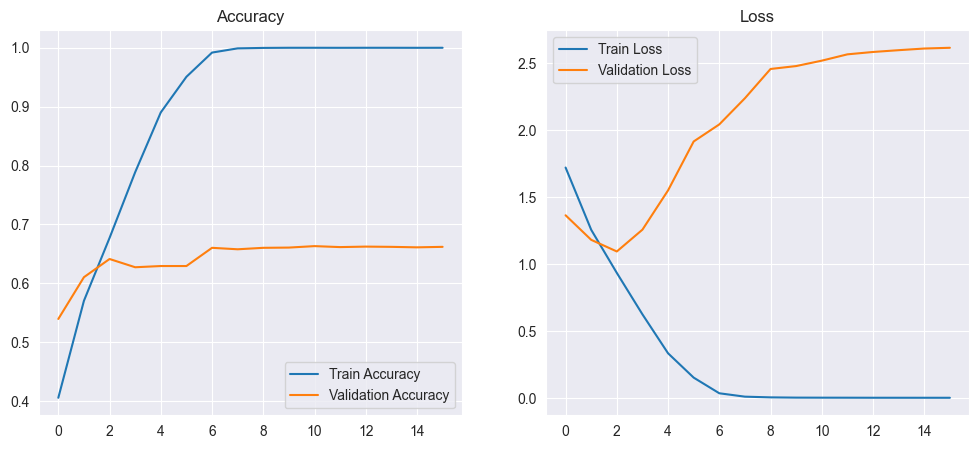

In [53]:
plot_learning_curves(history_phase_1)

152/152 [==============================] - 22s 146ms/step - loss: 2.4120 - accuracy: 0.6682
Test Loss: 2.411963701248169
Test Accuracy: 0.6681799292564392
152/152 [==============================] - 24s 156ms/step


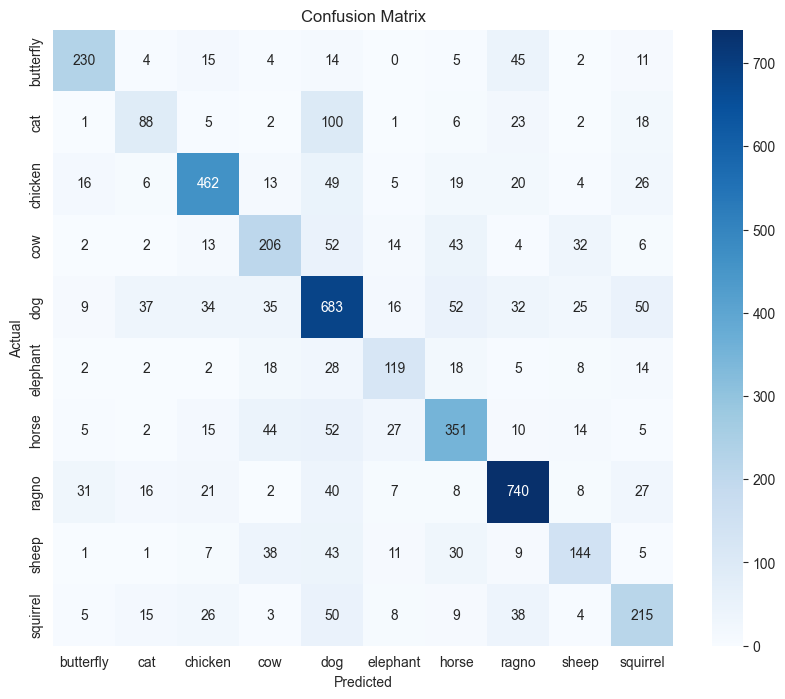

Classification Report:
              precision    recall  f1-score   support

   butterfly       0.76      0.70      0.73       330
         cat       0.51      0.36      0.42       246
     chicken       0.77      0.75      0.76       620
         cow       0.56      0.55      0.56       374
         dog       0.61      0.70      0.66       973
    elephant       0.57      0.55      0.56       216
       horse       0.65      0.67      0.66       525
       ragno       0.80      0.82      0.81       900
       sheep       0.59      0.50      0.54       289
    squirrel       0.57      0.58      0.57       373

    accuracy                           0.67      4846
   macro avg       0.64      0.62      0.63      4846
weighted avg       0.67      0.67      0.67      4846



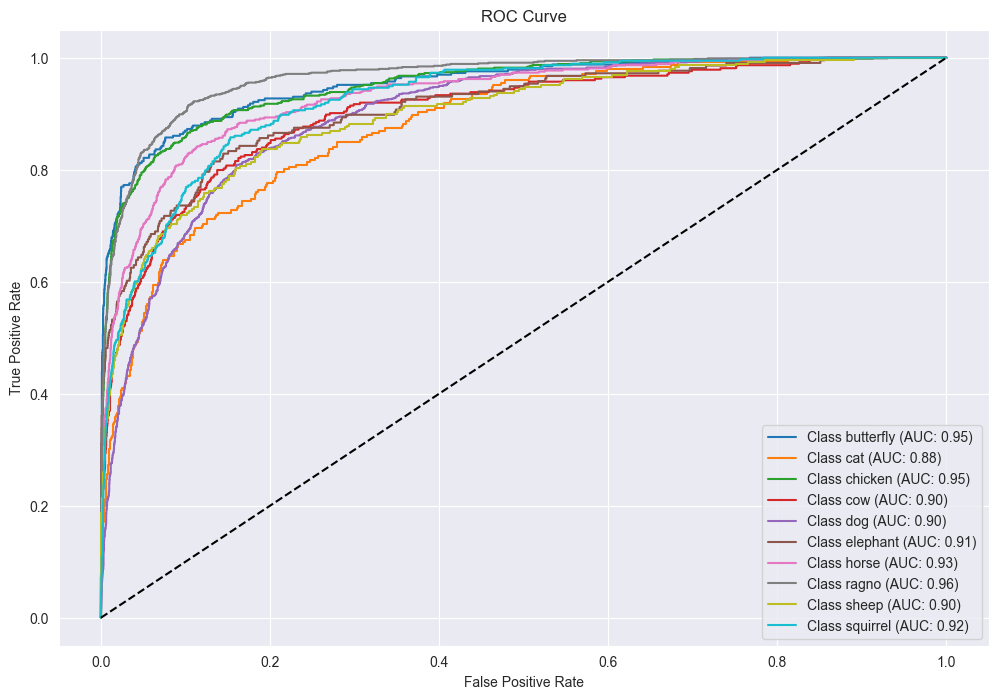

In [54]:
evaluate_model(model_phase_1, test_generator)

1/1 [==============================] - 0s 218ms/step


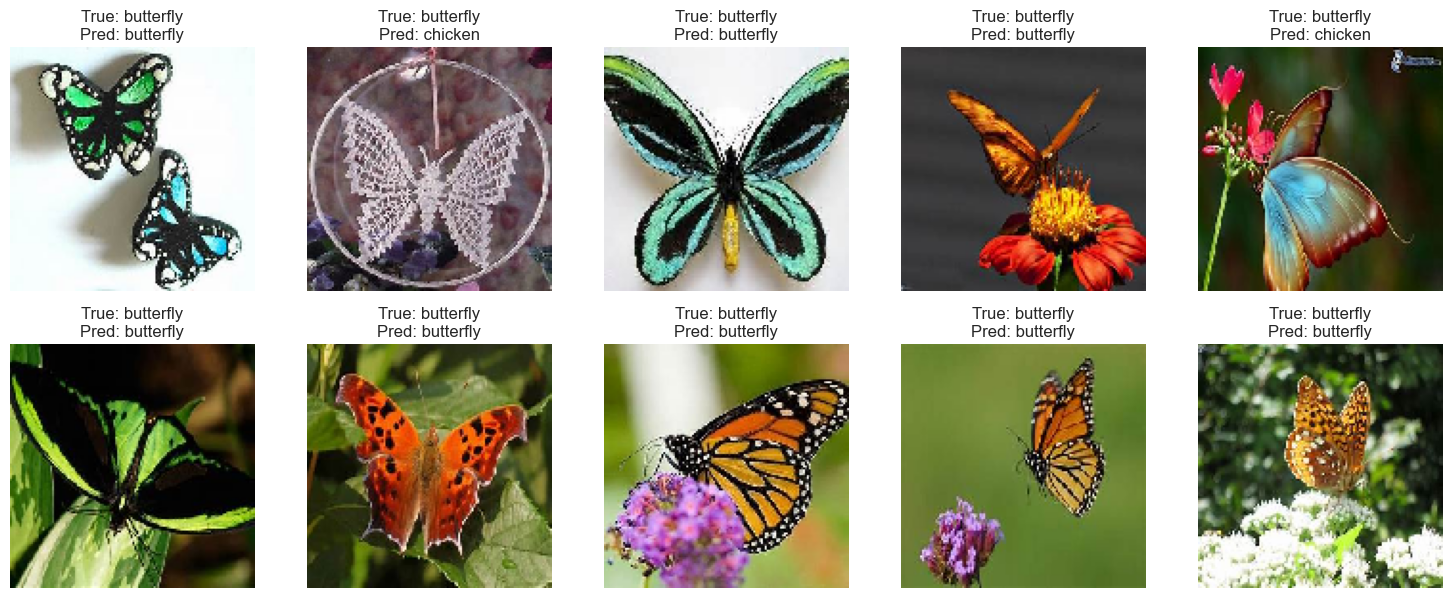

In [55]:
visualize_random_predictions(model_phase_1, test_generator)

# Execution for Phase 2

In [56]:
model_phase_2 = create_phase_2_model(model_phase_1)
history_phase_2 = train_model(model_phase_2, train_generator, val_generator, phase=2)

Epoch 1/20
530/530 [==============================] - 238s 446ms/step - loss: 1.1840 - accuracy: 0.6021 - val_loss: 1.0069 - val_accuracy: 0.6680 - lr: 0.0010
Epoch 2/20
530/530 [==============================] - 261s 492ms/step - loss: 0.6517 - accuracy: 0.7782 - val_loss: 1.0550 - val_accuracy: 0.6643 - lr: 0.0010
Epoch 3/20
530/530 [==============================] - 291s 549ms/step - loss: 0.2916 - accuracy: 0.9038 - val_loss: 1.3749 - val_accuracy: 0.6705 - lr: 0.0010
Epoch 4/20
530/530 [==============================] - 280s 529ms/step - loss: 0.1309 - accuracy: 0.9570 - val_loss: 1.5696 - val_accuracy: 0.6590 - lr: 0.0010
Epoch 5/20
530/530 [==============================] - 254s 479ms/step - loss: 0.0298 - accuracy: 0.9933 - val_loss: 1.7550 - val_accuracy: 0.6829 - lr: 2.0000e-04
Epoch 6/20
530/530 [==============================] - 279s 525ms/step - loss: 0.0059 - accuracy: 0.9998 - val_loss: 1.8886 - val_accuracy: 0.6878 - lr: 2.0000e-04
Epoch 7/20
530/530 [==================

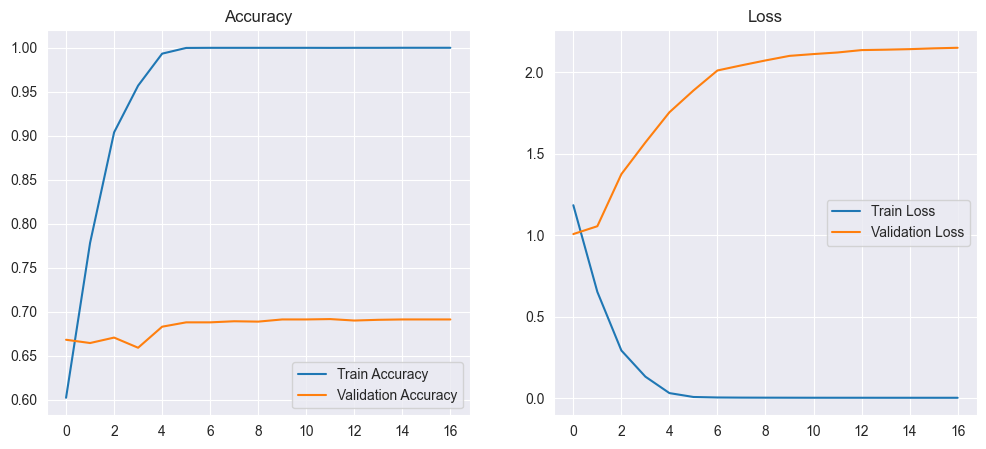

In [57]:
plot_learning_curves(history_phase_2)

152/152 [==============================] - 19s 122ms/step - loss: 2.0496 - accuracy: 0.6876
Test Loss: 2.0496468544006348
Test Accuracy: 0.6875773668289185
152/152 [==============================] - 17s 110ms/step


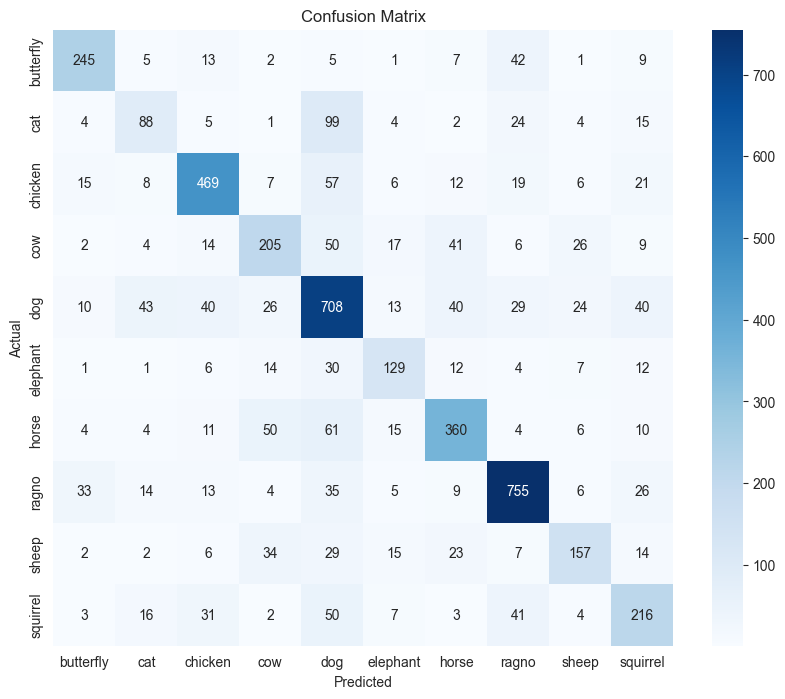

Classification Report:
              precision    recall  f1-score   support

   butterfly       0.77      0.74      0.76       330
         cat       0.48      0.36      0.41       246
     chicken       0.77      0.76      0.76       620
         cow       0.59      0.55      0.57       374
         dog       0.63      0.73      0.68       973
    elephant       0.61      0.60      0.60       216
       horse       0.71      0.69      0.70       525
       ragno       0.81      0.84      0.82       900
       sheep       0.65      0.54      0.59       289
    squirrel       0.58      0.58      0.58       373

    accuracy                           0.69      4846
   macro avg       0.66      0.64      0.65      4846
weighted avg       0.69      0.69      0.68      4846



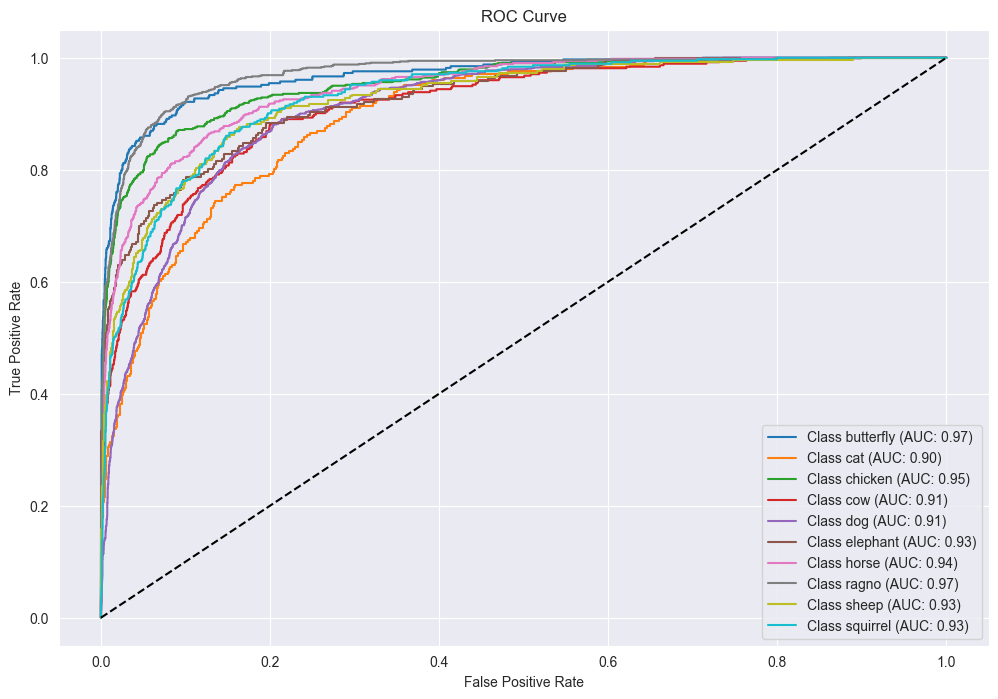

In [58]:
evaluate_model(model_phase_2, test_generator)

1/1 [==============================] - 0s 215ms/step


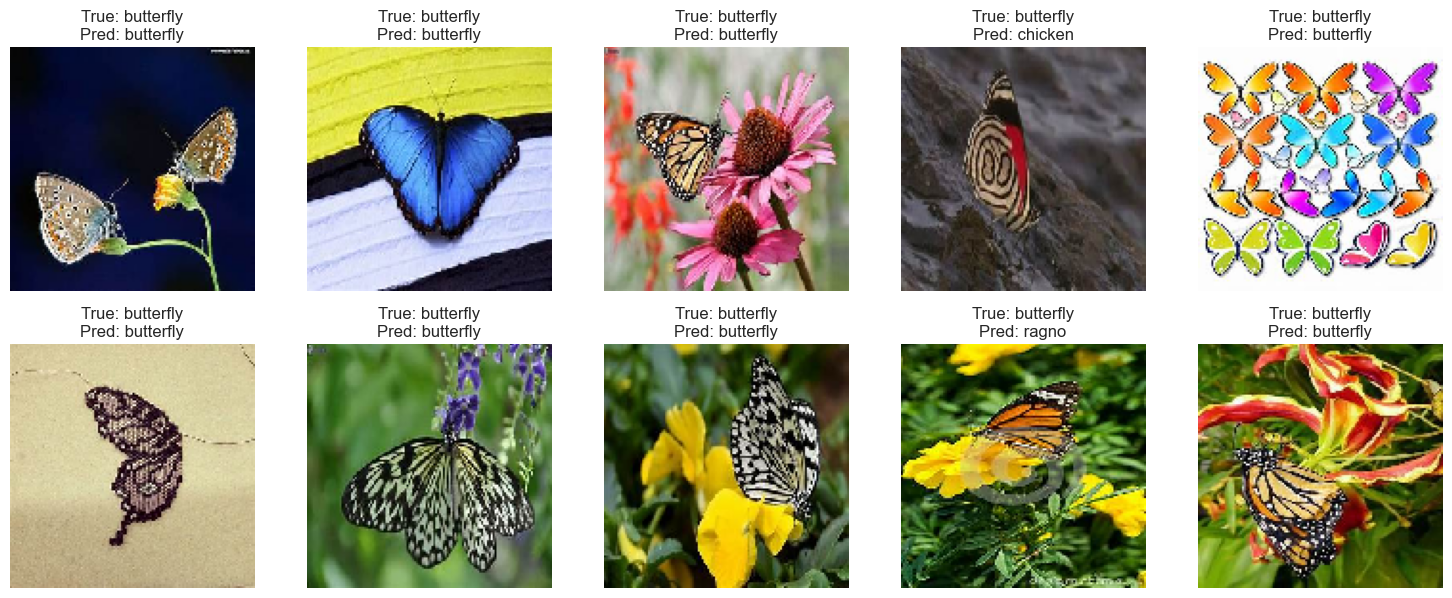

In [59]:
visualize_random_predictions(model_phase_2, test_generator)

# Execution for Phase 3: Prevent Overfitting (Phase 1 and Phase 2 models)

In [60]:
train_generator, val_generator, test_generator = create_data_generators(phase=3)

Found 16938 images belonging to 10 classes.
Found 2425 images belonging to 10 classes.
Found 4846 images belonging to 10 classes.


In [61]:
model_phase_1 = apply_overfitting_prevention(model_phase_1)
history_phase_1_overfit = train_model(model_phase_1, train_generator, val_generator, phase=3)

Epoch 1/20
530/530 [==============================] - 273s 511ms/step - loss: 2.3917 - accuracy: 0.4501 - val_loss: 1.4786 - val_accuracy: 0.5443 - lr: 1.0000e-04
Epoch 2/20
530/530 [==============================] - 288s 543ms/step - loss: 1.5589 - accuracy: 0.4802 - val_loss: 1.3490 - val_accuracy: 0.5703 - lr: 1.0000e-04
Epoch 3/20
530/530 [==============================] - 302s 569ms/step - loss: 1.4429 - accuracy: 0.5156 - val_loss: 1.2535 - val_accuracy: 0.5967 - lr: 1.0000e-04
Epoch 4/20
530/530 [==============================] - 300s 566ms/step - loss: 1.3582 - accuracy: 0.5417 - val_loss: 1.2599 - val_accuracy: 0.5839 - lr: 1.0000e-04
Epoch 5/20
530/530 [==============================] - 415s 784ms/step - loss: 1.3168 - accuracy: 0.5526 - val_loss: 1.2634 - val_accuracy: 0.5872 - lr: 1.0000e-04
Epoch 6/20
530/530 [==============================] - 297s 560ms/step - loss: 1.2847 - accuracy: 0.5619 - val_loss: 1.2481 - val_accuracy: 0.5889 - lr: 1.0000e-04
Epoch 7/20
530/530 [==

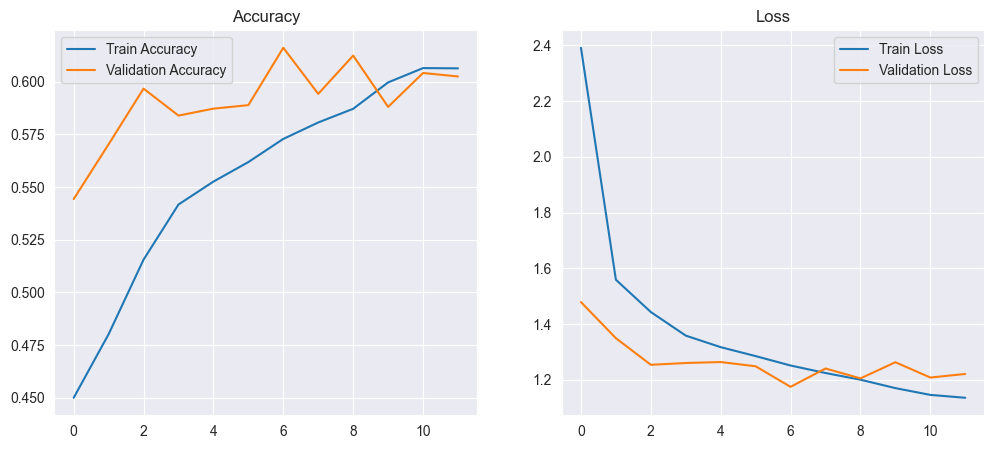

In [62]:
plot_learning_curves(history_phase_1_overfit)

152/152 [==============================] - 22s 145ms/step - loss: 1.1330 - accuracy: 0.6279
Test Loss: 1.1330149173736572
Test Accuracy: 0.6279405951499939
152/152 [==============================] - 18s 115ms/step


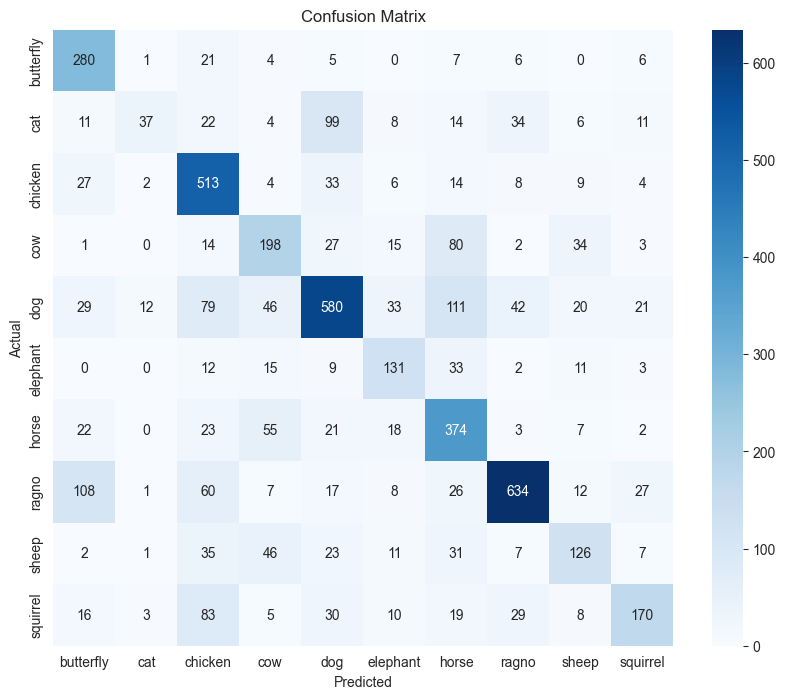

Classification Report:
              precision    recall  f1-score   support

   butterfly       0.56      0.85      0.68       330
         cat       0.65      0.15      0.24       246
     chicken       0.60      0.83      0.69       620
         cow       0.52      0.53      0.52       374
         dog       0.69      0.60      0.64       973
    elephant       0.55      0.61      0.57       216
       horse       0.53      0.71      0.61       525
       ragno       0.83      0.70      0.76       900
       sheep       0.54      0.44      0.48       289
    squirrel       0.67      0.46      0.54       373

    accuracy                           0.63      4846
   macro avg       0.61      0.59      0.57      4846
weighted avg       0.64      0.63      0.62      4846



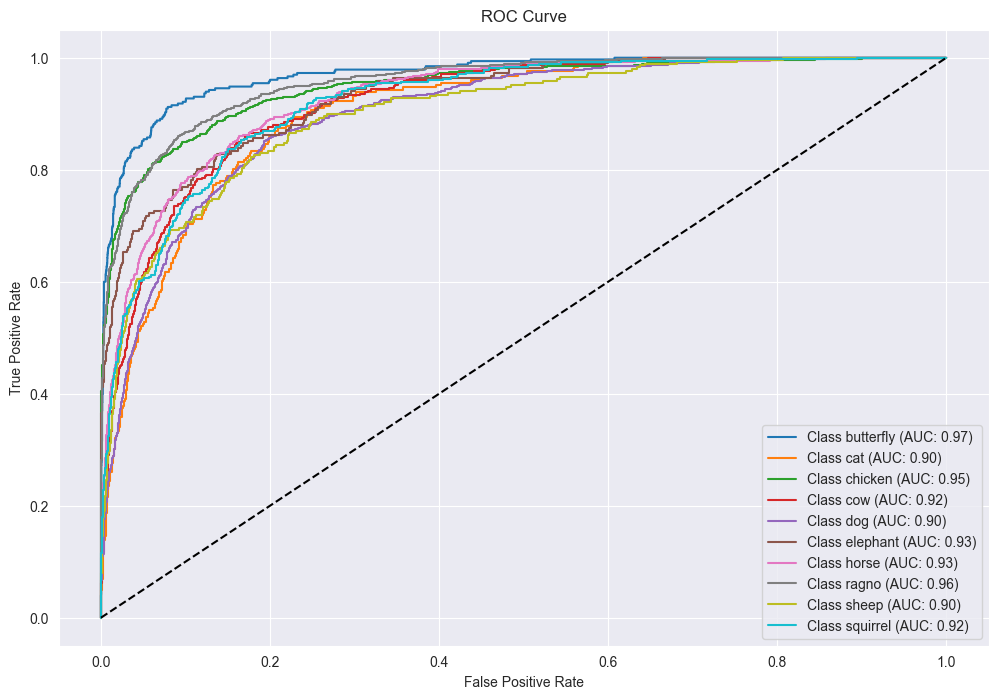

In [63]:
evaluate_model(model_phase_1, test_generator)

1/1 [==============================] - 0s 166ms/step


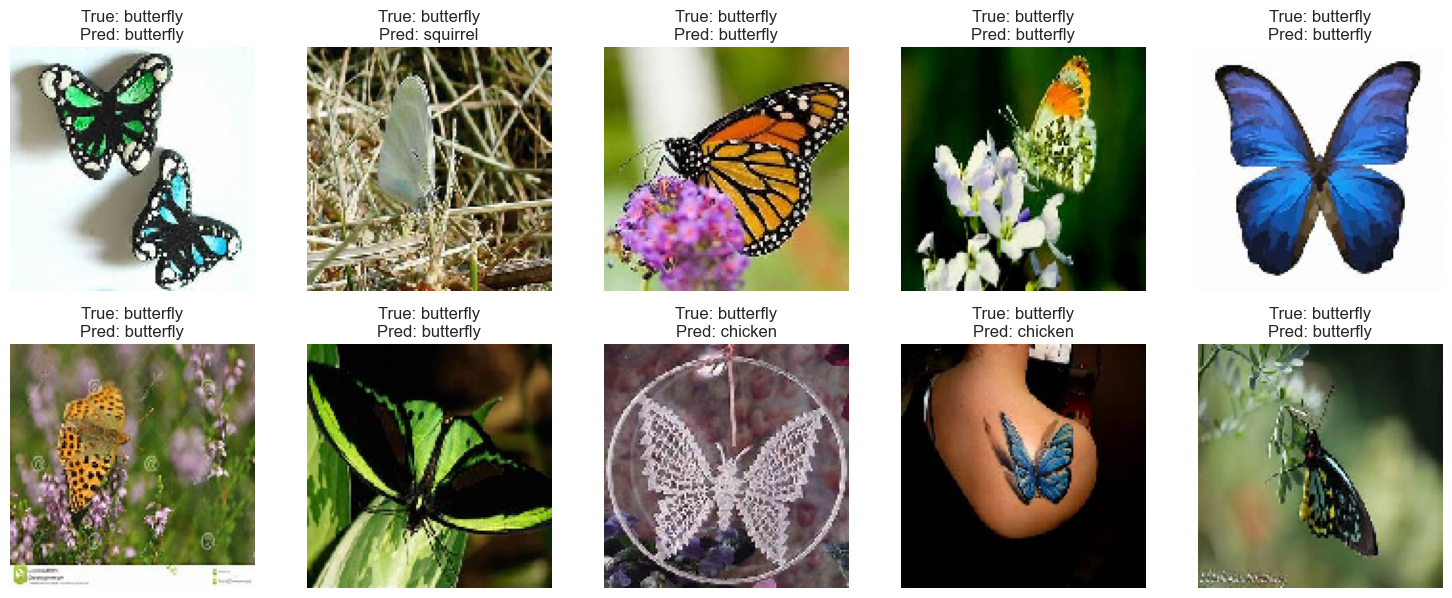

In [64]:
visualize_random_predictions(model_phase_1, test_generator)

In [65]:
model_phase_2 = apply_overfitting_prevention(model_phase_2)
history_phase_2_overfit = train_model(model_phase_2, train_generator, val_generator, phase=3)

Epoch 1/20
530/530 [==============================] - 254s 476ms/step - loss: 1.4666 - accuracy: 0.5188 - val_loss: 1.1677 - val_accuracy: 0.6074 - lr: 1.0000e-04
Epoch 2/20
530/530 [==============================] - 226s 426ms/step - loss: 1.2653 - accuracy: 0.5654 - val_loss: 1.1939 - val_accuracy: 0.6078 - lr: 1.0000e-04
Epoch 3/20
530/530 [==============================] - 228s 429ms/step - loss: 1.2081 - accuracy: 0.5871 - val_loss: 1.1666 - val_accuracy: 0.6058 - lr: 1.0000e-04
Epoch 4/20
530/530 [==============================] - 229s 432ms/step - loss: 1.1706 - accuracy: 0.5959 - val_loss: 1.1567 - val_accuracy: 0.6095 - lr: 1.0000e-04
Epoch 5/20
530/530 [==============================] - 232s 438ms/step - loss: 1.1465 - accuracy: 0.6063 - val_loss: 1.1265 - val_accuracy: 0.6202 - lr: 1.0000e-04
Epoch 6/20
530/530 [==============================] - 238s 448ms/step - loss: 1.1195 - accuracy: 0.6149 - val_loss: 1.1168 - val_accuracy: 0.6227 - lr: 1.0000e-04
Epoch 7/20
530/530 [==

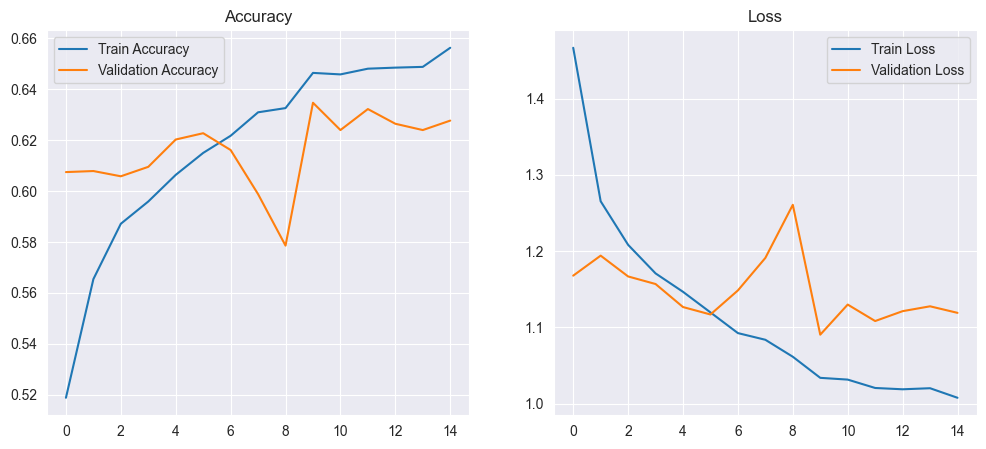

In [66]:
plot_learning_curves(history_phase_2_overfit)

152/152 [==============================] - 26s 173ms/step - loss: 1.0607 - accuracy: 0.6525
Test Loss: 1.0606600046157837
Test Accuracy: 0.6524969339370728
152/152 [==============================] - 16s 103ms/step


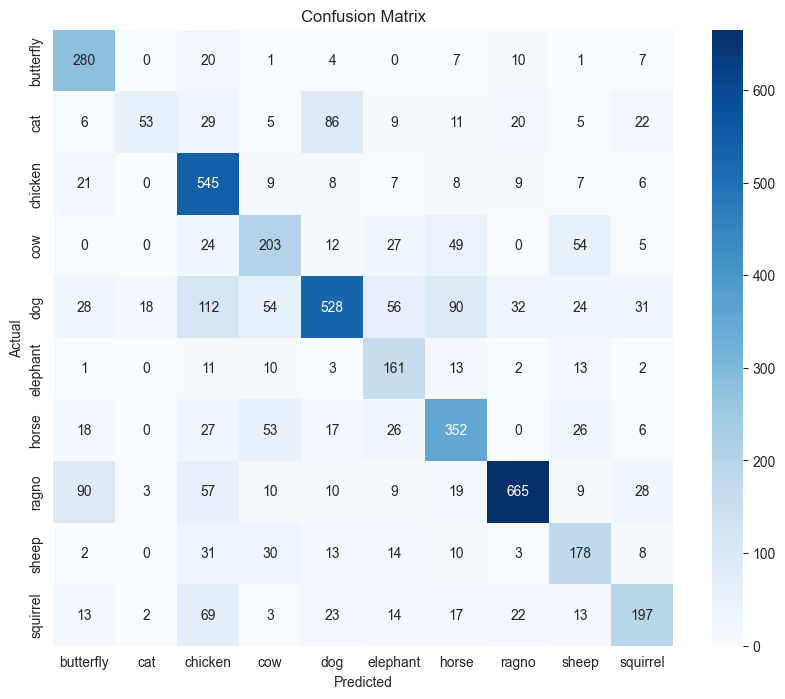

Classification Report:
              precision    recall  f1-score   support

   butterfly       0.61      0.85      0.71       330
         cat       0.70      0.22      0.33       246
     chicken       0.59      0.88      0.71       620
         cow       0.54      0.54      0.54       374
         dog       0.75      0.54      0.63       973
    elephant       0.50      0.75      0.60       216
       horse       0.61      0.67      0.64       525
       ragno       0.87      0.74      0.80       900
       sheep       0.54      0.62      0.58       289
    squirrel       0.63      0.53      0.58       373

    accuracy                           0.65      4846
   macro avg       0.63      0.63      0.61      4846
weighted avg       0.68      0.65      0.65      4846



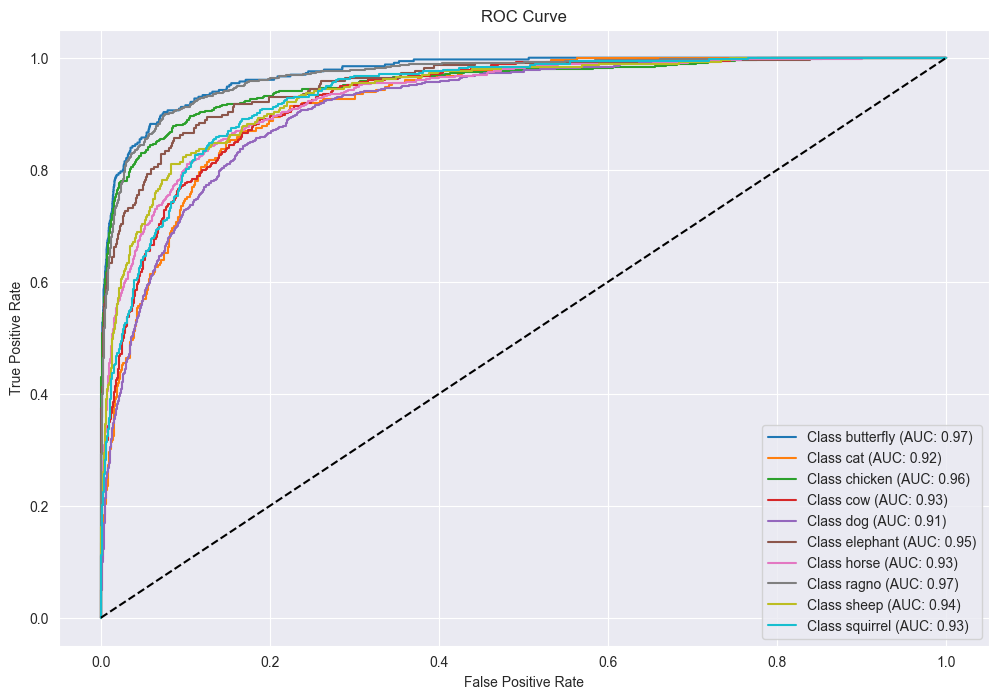

In [67]:
evaluate_model(model_phase_2, test_generator)

1/1 [==============================] - 0s 153ms/step


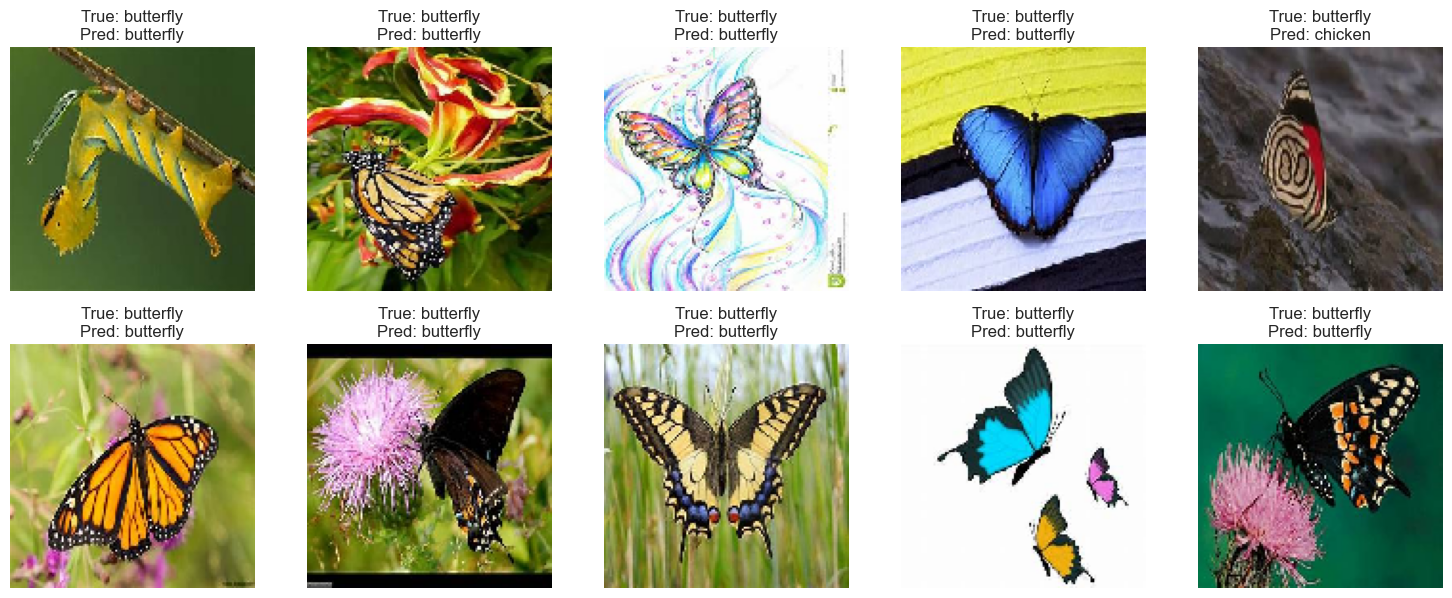

In [68]:
visualize_random_predictions(model_phase_2, test_generator)